In [55]:
from scipy.fftpack import dct
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt 
import numpy as np

In [22]:
(sample_rate1,sig1) = wav.read("wave0002.wav") ## Apple sound first
(sample_rate2,sig2) = wav.read("wave0001.wav") ## Apple sound Second
print(sig1[20 :100])
print(sig2[20 :100])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  2  2  2  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -2 -3 -3 -2 -4 -5 -5 -6 -6 -5 -4 -3 -5
 -4 -3 -2 -1  0  2  4  4]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  2  2  2  2  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
 -1 -2 -2 -2 -2 -1 -1  0 -1 -2 -3 -3 -3 -2 -2 -2 -2 -2 -2 -2 -1 -1 -1  0
  0  0  0  0 -2 -3 -3 -4]


In [4]:
print(rate1)
print(sig1.size)
print("FPS : ",sig1.size/float(rate1))
print(rate2)
print(sig2.size)
print("FPS : ",sig2.size/float(rate2))

16000
44800
FPS :  2.8
16000
40800
FPS :  2.55


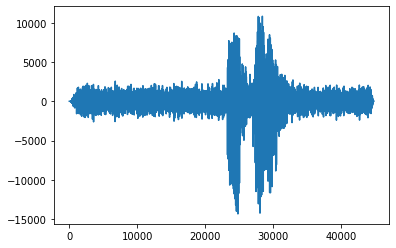

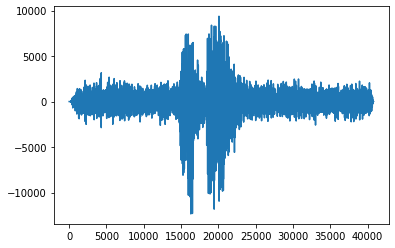

In [5]:
plt.plot(sig1)
plt.show()
plt.plot(sig2)
plt.show()

In [6]:
t1 = np.arange(sig1.size)/float(rate1)
t2 = np.arange(sig2.size)/float(rate2) 

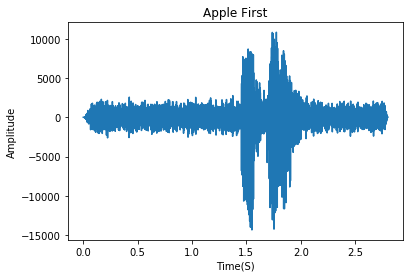

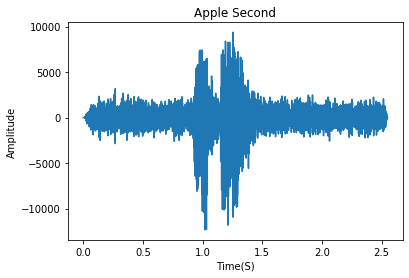

In [16]:
plt.plot(t1,sig1)
plt.title("Apple First")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude")
plt.show()
plt.plot(t2,sig2)
plt.title("Apple Second")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude")
plt.show()

# Pre-Emphasis

The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies. A pre-emphasis filter is useful in several ways: 

1. balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies.


2. avoid numerical problems during the Fourier transform operation.


3. may also improve the Signal-to-Noise Ratio (SNR).

The pre-emphasis filter can be applied to a signal x using the first order filter in the following equation:

                                    y(t)=x(t)−αx(t−1)
                                    
which can be easily implemented using the following line, where typical values for the filter coefficient (α) are 0.95 or 0.97, pre_emphasis = 0.97:

In [17]:
## First Apple Spoken Signal
pre_emphasis1 = 0.97
emphasized_signal1 = np.append(sig1[0], sig1[1:] - pre_emphasis1 * sig1[:-1])

In [20]:
## Second Apple Spoken Signal
pre_emphasis2 = 0.97
emphasized_signal2 = np.append(sig2[0], sig2[1:] - pre_emphasis2 * sig2[:-1])

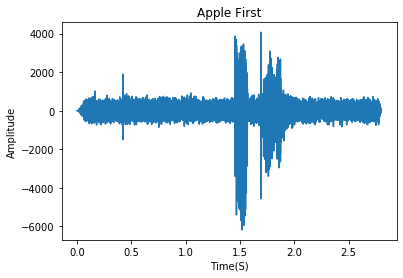

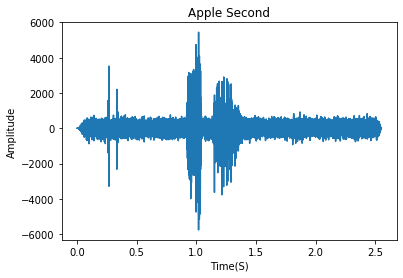

In [21]:
plt.plot(t1,emphasized_signal1)
plt.title("Apple First")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude")
plt.show()
plt.plot(t2,emphasized_signal2)
plt.title("Apple Second")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude")
plt.show()

# Framimg
After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size
        
                                        frame_size = 0.025
                                        frame_stride = 0.01(10ms).

In [36]:
## First Apple Spoken Signal

frame_size = 0.025
frame_stride = 0.01

## Convert from seconds to samples
frame_length, frame_step = frame_size * sample_rate1, frame_stride * sample_rate1
signal_length = len(emphasized_signal1)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

# Window
After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:

                            w[n] = 0.54−0.46*cos(2πn/(N−1))

where, 0 ≤ n ≤ N−1, N is the window length.

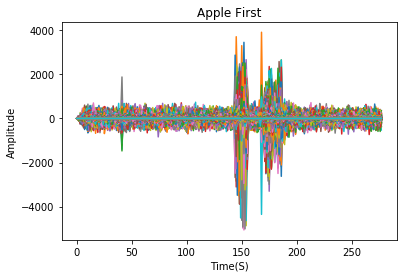

In [52]:
frames *= np.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **
plt.plot(frames)
plt.title("Apple First")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude")
plt.show()

# Fourier-Transform and Power Spectrum
We can now do an N-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where N is typically 256 or 512 and then compute the power spectrum (periodogram) using the following equation:

                                P=|FFT(x^i)|^2/N

where, x^i is the ith frame of signal x.


In [45]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

# Filter Banks
The final step to computing filter banks is applying triangular filters, typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands. The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. We can convert between Hertz (f) and Mel (m) using the following equations:

                                m = 2595log10(1+f/700)
                                
                                f = 700(10^(m/2595)−1)
                                


In [49]:
low_freq_mel = 0
nfilt = 40
high_freq_mel = (2595 * np.log10(1 + (sample_rate1 / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate1)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

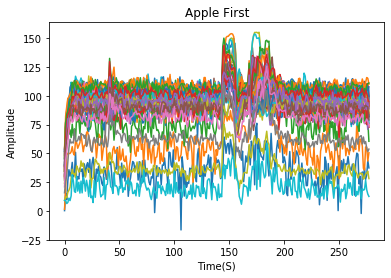

In [51]:
plt.plot(filter_banks)
plt.title("Apple First")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude")
plt.show()

# Mel-frequency Cepstral Coefficients (MFCCs)
It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; num_ceps = 12. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

In [57]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

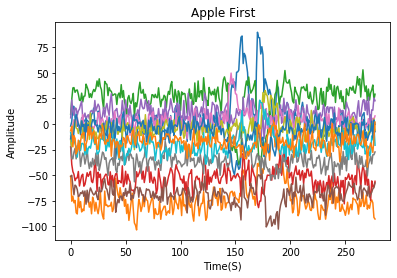

In [58]:
plt.plot(mfcc)
plt.title("Apple First")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude")
plt.show()

One may apply sinusoidal liftering1 to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals.


In [60]:
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift  #*

NameError: name 'cep_lifter' is not defined